# 강화학습 Deep Q Learning 튜토리얼 

이 튜토리얼에선 PyTorch를 이용해서 OpenAI Gym의 CartPole-v0 태스크에서 DQN 에이전트를 학습할 것이다.



## 태스크 
에이전트는 연결된  막대가 똑바로 서 있도록 카트를 왼쪽이나 오른쪽으로 움직이는 동작 중 하나를 선택해야한다. 다양한 알고리즘 시각화 기능을 갖추 공식 순위표를 Gym 웹사이트에서 찾을수 있다. 

에이전트가 현대 환경상태를 관찰하고 행동을 선택하면 환경이 새로운 상태고 바뀌고 작업의 결과를 나타내는 보상도 반환한다. 이 태스크에서 매 타임스텝이 증가하면서 보상이 +1이 되고 만약 막대가 너무 멀리 떨어지거나 카트가 중심에서 2.4유닛 이상 멀어지면 환경이 중단된다. 이는 더 좋은 시나리오가 더 오랫동안 더 많은 보상을 축적하는것을 의미한다.

카트폴 태스크는 에이전트에 대한 입력이 환경상태(위치, 속도 등)을 나타내는 4개의 실제값이 되도록 설계되었다. 그러나 신경망을 순수하게 그 장면을 보고 태스크를 해결할 수 있다. 따라서 카트 중심의 화면 패치를 입력으로 사용한다. 이로 인해 결과는 공식 순위표의 결과와 직접적으로 비교할 수 없다. 이 튜토리얼에선 모든 프레임을 렌더링 해야 하므로 학습속도가 느리다.

## 패키지

In [1]:
! pip install gym

You should consider upgrading via the 'c:\users\sanghyeon cho\anaconda\python.exe -m pip install --upgrade pip' command.


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# matplotlib 설정 
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

# GPU를 사용할 경우
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [3]:
!pip install gym[all]

  Using cached lz4-4.0.0-cp38-cp38-win_amd64.whl (96 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\sanghyeon cho\anaconda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Sanghyeon Cho\\AppData\\Local\\Temp\\pip-install-l621qqwl\\box2d-py_bc2e133c0fa8443b801b564accd369bc\\setup.py'"'"'; __file__='"'"'C:\\Users\\Sanghyeon Cho\\AppData\\Local\\Temp\\pip-install-l621qqwl\\box2d-py_bc2e133c0fa8443b801b564accd369bc\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Sanghyeon Cho\AppData\Local\Temp\pip-wheel-fmhcarlr'
       cwd: C:\Users\Sanghyeon Cho\AppData\Local\Temp\pip-install-l621qqwl\box2d-py_bc2e133c0fa8443b801b564accd369bc\
  Complete output (16 lines):
  Using setuptools (version 50.3.1.post20201107).
  running bdist_wheel



  Using cached ale_py-0.7.4-cp38-cp38-win_amd64.whl (904 kB)
  Running setup.py clean for box2d-py
  Running setup.py clean for mujoco-py
Failed to build box2d-py mujoco-py
    Running setup.py install for mujoco-py: started
    Running setup.py install for mujoco-py: finished with status 'error'



  copying library\Box2D\Box2D.py -> build\lib.win-amd64-3.8\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-3.8\Box2D
  creating build\lib.win-amd64-3.8\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-3.8\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
  error: command 'swig.exe' failed: No such file or directory
  ----------------------------------------
  ERROR: Failed building wheel for box2d-py
  ERROR: Command errored out with exit status 1:
   command: 'c:\users\sanghyeon cho\anaconda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Sanghyeon Cho\\AppData\\Local\\Temp\\pip-install-l621qqwl\\mujoco-py_f467839fad1245039e04d9f3c978bc37\\setup.py'"'"'; __fi

## 재현 메모리(Replay Memory)

DQN 학습을 위해 경험 재현 메모리를 사용할 것이다. 에이전트가 관찰한 transition을 저장하고 추후에 이 데이터를 재사용할 수 있다. 무작위로 샘플링을 하게되면 배치를 구성하는 전환들이 상관관계를 가지지 않기 떄문에 DQN 학습절차를 안정시키고 향상 시킬수 있다. 

이를 위해 두가지 클래스가 필요하다. 

- Transition : 우리 환경에서 단일 전환을 나타내도록 명명된 튜플로 화면의 차이인 state로 (state, action) 쌍을 (next_state, reward ) 결과로 매핑
- ReplayMemory : 최근 관찰된 전이를 보관 및 유지하는 제한된 크기의 순환 버퍼. 학습을 위한 random transition batch를 선택하기 위한 .sample() 메소드를 구현한다. 

In [3]:
Transition = namedtuple("Transition", ("state", 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## DQN 알고리즘 

환경은 결정론적이므로 여기에 제시된 모든 방정식은 단순화를 위해 결정론적으로 공식화 된다. 강화학습 자료는 환경에서 확률론적 전환에 대한 기대갑도 포함된다.

목표는 discounted cumulative reward를 극대화 하려는 policy를 학습하는것이다.

Reward 수식 

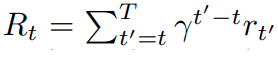

감마는 discount factor로 0과 1의 상수이고 합계가 수렴되도록 보장하는데 이는 에이전트에게 현재상태에서 먼 시점의 보상이 가까운 시점의 보상보다 덜 중요하게 만든다. 

Q-learning의 주요 아이디어는 만일 함수 Q* : State x Action -> R을 가지고 있다면 reward가 어떻게 될지 알려줄수 있고 만약 주어진 상태에서 행동을 한다면 보상을 최대화하는 policy를 구출할수 있다.
하지만 Q에 도달하는 것이 쉽지않다. 하지만 신경망은 universal fuction approximator이기 때문에 간단하게 생성하고 Q* 를 닮도록 학습할 수 있다.

학습 업데이트 규칙으로, 일부 policy를 위한 모든 Q 함수가 Bellman 방정식을 준수한다는 사실을 사용할 것이다.
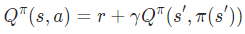

등호를 두고 양쪽의 차이는 temporal difference error이다. 
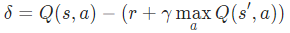

이 에러를 줄이기 위해 HUber loss를 사용할 것이다. HUber loss는 오류가 작으면 MSE와 같이 동작하고, 오류가 크면 MAE롸 같이 동작한다. 이는 Q의 추정에 noise가 많을떄 이상치에대해 더욱 강건하게 한다. Replay Memory에서 샘플링한 transition batch B에서 이것을 계산한다.

## Q-Network

모델은 현재와 이전 스크린 패치의 차이를 취하는 CNN이다. 출력은 Q(s,left)와 Q(s,right)가 있다. s는 네트워크의 입력이다.
결과적으로 네트워크는 현재입력에서 각 행동의 기대값을 예측하려고 한다. 

In [4]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Linear의 입력의 연결 숫자는 conv2d 계층의 출력과 입력 이미지의 크기에 따라 결정되기 떄문에 따로 계산
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size-(kernel_size-1)-1)// stride + 1
        convw = conv2d_size_out( conv2d_size_out( conv2d_size_out(w)))
        convh = conv2d_size_out( conv2d_size_out( conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
        #최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호출
        def forward(self, x):
            x = x.to(device)
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.relu(self.bn3(self.conv3(x)))
            return self.head(x.view(x.size(0), -1))
        
        

## 입력 추출 

In [ ]:
resize = T.Compose([T.ToPILImage(),
                   T.Resize(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만 800*1200*3 처럼 큰 경우가 있따.
    #이것을 Torch order(CHW)로 변환
    screen = env.render(mode='rgb_array').transpose((2,0,1))
    _, screen_height, screen_width = screen.shape
    screen = screen[: int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width//2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width//2):
        slice_range = slice(-view_width, None)
    else: 
        slice_range = slice(cart_location - view_width //2,
                            cart_location + view_width //2)
    # 카트를 중심으로 정사각형 이미지가 되도록 가장자리 제거 
    screen = screen[:, :, slice_range]
    #float로 변환하고, rescale하고 torch tensor로 변환
    screen = np.ascontiguousarray(screen, dtype=np.float32)/256
    screen = torch.from_numpy(screen)
    
    return resize(screen).unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(),interpolation='none')
plt.title('Example extracted screen')
plt.show

C:\Users\Sanghyeon Cho\ANACONDA\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
C:\Users\Sanghyeon Cho\ANACONDA\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


## 학습 
모델과 옵티마이저를 인스턴스화 하고 일부 유틸리티를 정의 

- selection_action : Epsilon greedy policy에 딸라 행동을 선택한다. 즉, 가끔 모델을 사용하여 행동을 선택하고 떄로는 단지 하는 균일하게 샘플링 하는것을 의미한다. 임의의 액션을 선택할 확률은 EPS_START에서 EPS_END를 향해 지수적으로 감소할 것이다. EPS_DECAY는 decay 속도를 제어한다.

- plot_duration : 지난 100개 에피소드의 평균에 따른 에피소드의 지속을 도표로 그리기 위한 헬퍼이다. 도표는 기본 훈련 루프가 포함된 셑 밑에 있으며, 매 에피소드마다 업데이트 된다.  

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# AI gym에서 반환된 형태를 기반으로 계층을 초기화 하도록 화면의 크기를 가져옴.
# 이 시점에 일반적으로 3*40*90에 가까움.
# 이 크기는 get_screen()에서 고정. 축소된 렌더 버퍼의 결과임.

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# gym 행동공간에서 행동의 숫자를 얻음
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(polict_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) *\math.exp(-1. * steps_done /EPS_DECAY)
    steps_done +=1
    if smaple > eps_threshold:
        with torch.no_grad():
            # t.max(1)은 각 행의 가장 큰 열 값을 반환
            # 최대 결과의 두번쨰 열은 최대 요소의 주소값이므로,
            # 기대보상이 더큰 행동을 선택할수 있음 
            return policy_net(state).max(1)[1].view(1,1)
    else: 
        return torch.tensor([[rnadom.randrange(n_actions)]], device=device, dtype=torch.long)
    
    episode_duration = []
    
    def plot_duration():
        plt.figure(2)
        plt.clf()
        durations_t = torch.tensor(episode_durations, dtype=torch.float)
        plt.title('Training...')
        plt.xlabel("Episode")
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # 100개의 에피소드 평균을 가져와서 도표 그리기
        if len(durations_t) >= 100:
            means = durations_t.unifold(0,100,1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())
            
        plt.pause(0.001)
        if is_ipython:
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
        

## 학습루프 
최종적으로 모델 학습을 위한 코드 

여기서 최적화의 한단계를 수행하는 optimize_model 함수를 찾을수 있다. 
먼저 배치 하나를 샘플링하고 모든 tensor를 하나로 연결하고  Q(s_t, a_t)와 
V(s_t+1) = max_a Q(s_{t+1}, a)를 계산하고 그것들을 손실호 합친다
설정한 정의에 따르면 만약 s가 마지막 상태라면 V(s) = 0이다. 또한 안정성을 추가하기 위한 V(s_t+1)계산을 위해 target network를 사용한다.
target network는 대부분의 시간동안 가중치가 고정되지만, 가끔 policy network의 가중치로 업데이트 된다.                              

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch -> batch-array의 transition을 transition의 batch-array로 변환
    batch = Transition(*zip(*transitions))
    
    # 최종이 아닌 상태의 마스크를 계산하고 배치요소를 연결
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                           batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state 
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    #Q(s_t, a)계산 -> 모델이 Q(s_t)를 계산하고 취한행동의 열을 선택
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #non_final_next_states의 행동들에 대한 기대값은 이전 target_net을 기반으로 계산
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    #Huber Loss 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()

### 주요 학습 루프 

1. 환경 재설정
2. 상태 tensor 초기화
3.다음 행동 샘플링
4.샘플링된 행동 실행 
5.다음 화면과 보상(항상 1)을 관찰
6.모델 최적화
7.에피소드가 끝나면 즉 모델이 실패하면 루프 다시시작

아래에선 에피소드의 수가 적지만 의미있는개선을 위해 더 높은수의 에피소드를 실행하는것을 권장한다. 

In [ ]:
num_episodes = 50
for i_episodes in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        #행동 선태과 수행
        action = select_action(state)
        _, reward, done, _, = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # 새로운 상태 관찰
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen = last_screen
        else:
            next_state = None
            
        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)
        
        # 다음 상태로 이동 
        state =next_state
        
        # policy network 에서 최적화 한단계 수행 
        optimize_model()
        if done: 
            episode_durations.append(t +1)
            plot_durations()
            break
    # target 네트워크 업데이트 모든 weight, bias 복사 
    if i_episode % TRAGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print("Complete")
env.render()
env.close()
plt.ioff()
plt.show()

## 전체 결과 데이터 흐름을 보여주는 다이어그램 

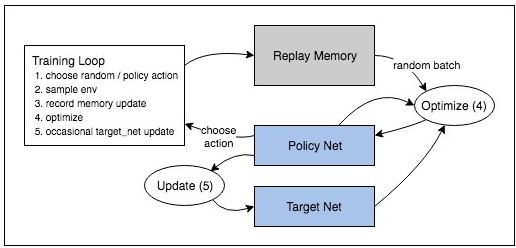

action은 무작위 또는 policy에따라 선택되어 gym 환경에서 다음 단계 샘플을 가져옴
결과를 Replay Memory에 저장하고 모든 반복에서 최적화 단계를 실행 
최적화는 Replay Memory에서 무작위 배치를 선택해 새 policy를 학습 
이전 target_net은 최적화에서 기대 Q값을 계산하는데 사용되고 최신상태 유지를 위해 가끔 업데이트 됨 